In [44]:
%load_ext autoreload
%autoreload 2

import plotly.graph_objs as go
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from plotly.subplots import make_subplots
from features import *
from genereted_features import *
from plots import plot_results

X = pd.read_csv(r"data/coin_Ethereum.csv", parse_dates=['Date'], index_col=['Date'])
X = X[["Open", "High", "Low", "Close", "Volume"]]
X = X.rename(columns={ i:i.lower() for i in ["Open", "High", "Low", "Close", "Volume"]})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Monte Carlo

In [18]:
import numpy as np
import pandas as pd

class MonteCarloCandleSimulation:
    def __init__(self, lookback=500, steps=10, simulations=500, return_style='log', flat_threshold_percent=0.5):
        self.lookback = lookback
        self.steps = steps
        self.simulations = simulations
        self.return_style = return_style
        self.flat_threshold_percent = flat_threshold_percent

    def calculate_returns(self, price_series):
        if self.return_style == 'log':
            return np.log(price_series / price_series.shift(1))
        else:
            return price_series.pct_change()

    def calculate_volatility(self, returns):
        return np.std(returns)

    def simulate_price_paths(self, start_price, returns, volatility):
        dt = 1 / self.steps
        price_paths = np.zeros((self.simulations, self.steps))

        for step in range(self.steps):
            if step == 0:
                price_paths[:, step] = start_price
            else:
                random_shock = np.random.normal(0, volatility*np.sqrt(dt), self.simulations)
                price_paths[:, step] = price_paths[:, step-1] * np.exp(random_shock)

        return price_paths

    def run_simulation(self, df):
            extended_df = df.copy()

            for i in range(len(df)):
                if i < self.lookback:
                    continue  # Skip initial period without enough lookback data

                window_data = df['close'].iloc[i-self.lookback:i]
                returns = self.calculate_returns(window_data).dropna()
                volatility = self.calculate_volatility(returns)

                start_price = window_data.iloc[-1]
                flat_threshold = start_price * self.flat_threshold_percent / 100
                simulated_price_paths = self.simulate_price_paths(start_price, returns, volatility)

                for step in range(self.steps):
                    current_simulated_prices = simulated_price_paths[:, step]
                    extended_df.loc[df.index[i], f'simulated_price_step_{step+1}'] = current_simulated_prices.mean()
                    
                    # Calculate probabilities with flat threshold
                    up_moves = current_simulated_prices > start_price + flat_threshold
                    down_moves = current_simulated_prices < start_price - flat_threshold
                    flat_moves = np.abs(current_simulated_prices - start_price) <= flat_threshold

                    prob_up = np.mean(up_moves)
                    prob_down = np.mean(down_moves)
                    prob_flat = np.mean(flat_moves)

                    extended_df.loc[df.index[i], 'MC_ProbabilityUp'] = prob_up
                    extended_df.loc[df.index[i], 'MC_ProbabilityDown'] = prob_down
                    extended_df.loc[df.index[i], 'MC_ProbabilityFlat'] = prob_flat

                    # Determine most likely direction
                    if prob_up > prob_down and prob_up > prob_flat:
                        direction = 1
                    elif prob_down > prob_up and prob_down > prob_flat:
                        direction = -1
                    else:
                        direction = 0

                    extended_df.loc[df.index[i], 'MC_MostLikelyDirection'] = direction

            return extended_df

steps = 10
mc_sim = MonteCarloCandleSimulation(simulations=100, steps=steps, lookback=50)
df_with_simulations = mc_sim.run_simulation(X)
#df_with_simulations[['close', 'simulated_price_step_1']].tail(20)
for i in range(1, steps):
    df_with_simulations["tmp"] = (df_with_simulations['close'].shift(-i) - df_with_simulations[f'simulated_price_step_{i}'])/ df_with_simulations['close']
    df_with_simulations["tmp2"] = (df_with_simulations['close'].shift(-i) - df_with_simulations['close'])/ df_with_simulations['close']

    print(i, df_with_simulations["tmp"].std() - df_with_simulations["tmp2"].std())

for i in range(1, steps):
    df_with_simulations["tmp3"] = np.sign(df_with_simulations['close'] - df_with_simulations[f'simulated_price_step_{i}'])
    df_with_simulations["tmp4"] = np.sign(df_with_simulations['close'] - df_with_simulations['close'].shift(-i))
    df_with_simulations["tmp5"] = df_with_simulations["tmp3"] / df_with_simulations["tmp4"] 
    counts = df_with_simulations["tmp5"].value_counts()
    print(i, counts[1]/(counts[1] + counts[-1]))

KeyboardInterrupt: 

In [23]:
!pip install ray
import ray
import numpy as np
import pandas as pd

# Initialize Ray
ray.init()

@ray.remote
def process_chunk(chunk, lookback, steps, simulations, return_style, flat_threshold_percent):
    mc_sim = MonteCarloCandleSimulation(lookback, steps, simulations, return_style, flat_threshold_percent)
    return mc_sim.run_chunk_simulation(chunk)

class MonteCarloCandleSimulation:
    def __init__(self, lookback=500, steps=10, simulations=500, return_style='log', flat_threshold_percent=0.5):
        self.lookback = lookback
        self.steps = steps
        self.simulations = simulations
        self.return_style = return_style
        self.flat_threshold_percent = flat_threshold_percent

    def calculate_returns(self, price_series):
        if self.return_style == 'log':
            return np.log(price_series / price_series.shift(1))
        else:
            return price_series.pct_change()

    def calculate_volatility(self, returns):
        return np.std(returns)

    def simulate_price_paths(self, start_value, returns, volatility):
        dt = 1 / self.steps
        paths = np.zeros((self.simulations, self.steps))

        for step in range(self.steps):
            if step == 0:
                paths[:, step] = start_value
            else:
                random_shock = np.random.normal(0, volatility * np.sqrt(dt), self.simulations)
                paths[:, step] = paths[:, step - 1] * np.exp(random_shock)

        return paths

    def run_chunk_simulation(self, chunk):
        extended_chunk = pd.DataFrame(index=chunk.index)

        for i in range(len(chunk)):
            if i < self.lookback:
                continue

            window_data_price = chunk['close'].iloc[i - self.lookback:i]
            returns_price = self.calculate_returns(window_data_price).dropna()
            volatility_price = self.calculate_volatility(returns_price)
            start_price = window_data_price.iloc[-1]
            flat_threshold = start_price * self.flat_threshold_percent / 100

            simulated_price_paths = self.simulate_price_paths(start_price, returns_price, volatility_price)
            for step in range(self.steps):
                current_simulated_prices = simulated_price_paths[:, step]
                extended_chunk.loc[chunk.index[i], f'simulated_price_step_{step + 1}'] = current_simulated_prices.mean()
                
                # Calculate probabilities with flat threshold
                up_moves = current_simulated_prices > start_price + flat_threshold
                down_moves = current_simulated_prices < start_price - flat_threshold
                flat_moves = np.abs(current_simulated_prices - start_price) <= flat_threshold

                prob_up = np.mean(up_moves)
                prob_down = np.mean(down_moves)
                prob_flat = np.mean(flat_moves)

                extended_chunk.loc[chunk.index[i], 'MC_ProbabilityUp'] = prob_up
                extended_chunk.loc[chunk.index[i], 'MC_ProbabilityDown'] = prob_down
                extended_chunk.loc[chunk.index[i], 'MC_ProbabilityFlat'] = prob_flat

                # Determine most likely direction
                if prob_up > prob_down and prob_up > prob_flat:
                    direction = 1
                elif prob_down > prob_up and prob_down > prob_flat:
                    direction = -1
                else:
                    direction = 0

                extended_chunk.loc[chunk.index[i], 'MC_MostLikelyDirection'] = direction

        return extended_chunk

    def run_simulation(self, df):
        # Break DataFrame into chunks for parallel processing
        df_chunks = np.array_split(df, self.simulations)
        
        # Dispatch tasks to Ray
        futures = [process_chunk.remote(chunk, self.lookback, self.steps, self.simulations, self.return_style, self.flat_threshold_percent) for chunk in df_chunks]

        # Gather and combine results
        results = ray.get(futures)
        extended_df = pd.concat(results)

        return extended_df

# Example usage
steps = 10
mc_sim = MonteCarloCandleSimulation(simulations=100, steps=steps, lookback=50)
df_with_simulations = mc_sim.run_simulation(X)


/opt/miniconda3/envs/mrr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-15 12:45:11,504	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-15 12:45:14,711	INFO worker.py:1724 -- Started a local Ray instance.
/opt/miniconda3/envs/mrr/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


KeyboardInterrupt: 

In [24]:
import numpy as np
import pandas as pd

class MonteCarloCandleSimulation:
    def __init__(self, lookback=500, steps=10, simulations=500, return_style='log', simulate_volume=False, simulate_volatility=False, flat_threshold_percent=0.5):
        self.lookback = lookback
        self.steps = steps
        self.simulations = simulations
        self.return_style = return_style
        self.simulate_volume = simulate_volume
        self.simulate_volatility = simulate_volatility
        self.flat_threshold_percent = flat_threshold_percent

    def calculate_returns(self, price_series):
        if self.return_style == 'log':
            return np.log(price_series / price_series.shift(1))
        else:
            return price_series.pct_change()

    def calculate_volatility(self, returns):
        return np.std(returns)

    def simulate_price_paths(self, start_value, returns, volatility):
        dt = 1 / self.steps
        paths = np.zeros((self.simulations, self.steps))

        for step in range(self.steps):
            if step == 0:
                paths[:, step] = start_value
            else:
                random_shock = np.random.normal(0, volatility * np.sqrt(dt), self.simulations)
                paths[:, step] = paths[:, step - 1] * np.exp(random_shock)

        return paths

    def run_simulation(self, df):
        extended_df = pd.DataFrame(index=df.index)

        for i in range(len(df)):
            if i < self.lookback:
                continue

            # Price Simulation
            window_data_price = df['close'].iloc[i - self.lookback:i]
            returns_price = self.calculate_returns(window_data_price).dropna()
            volatility_price = self.calculate_volatility(returns_price)
            start_price = window_data_price.iloc[-1]
            flat_threshold = start_price * self.flat_threshold_percent / 100

            if self.simulate_volume:
                # Volume Simulation
                window_data_volume = df['volume'].iloc[i - self.lookback:i]
                returns_volume = self.calculate_returns(window_data_volume).dropna()
                volatility_volume = self.calculate_volatility(returns_volume)
                start_volume = window_data_volume.iloc[-1]
                simulated_volume_paths = self.simulate_price_paths(start_volume, returns_volume, volatility_volume)
                for step in range(self.steps):
                    extended_df.loc[df.index[i], f'simulated_volume_step_{step + 1}'] = simulated_volume_paths[:, step].mean()

            if self.simulate_volatility:
                # Volatility Simulation
                simulated_volatility_paths = self.simulate_price_paths(volatility_price, returns_price, volatility_price)
                for step in range(self.steps):
                    extended_df.loc[df.index[i], f'simulated_volatility_step_{step + 1}'] = simulated_volatility_paths[:, step].mean()

            simulated_price_paths = self.simulate_price_paths(start_price, returns_price, volatility_price)
            for step in range(self.steps):
                current_simulated_prices = simulated_price_paths[:, step]
                extended_df.loc[df.index[i], f'simulated_price_step_{step + 1}'] = current_simulated_prices.mean()
                
                # Calculate probabilities with flat threshold
                up_moves = current_simulated_prices > start_price + flat_threshold
                down_moves = current_simulated_prices < start_price - flat_threshold
                flat_moves = np.abs(current_simulated_prices - start_price) <= flat_threshold

                prob_up = np.mean(up_moves)
                prob_down = np.mean(down_moves)
                prob_flat = np.mean(flat_moves)

                extended_df.loc[df.index[i], 'MC_ProbabilityUp'] = prob_up
                extended_df.loc[df.index[i], 'MC_ProbabilityDown'] = prob_down
                extended_df.loc[df.index[i], 'MC_ProbabilityFlat'] = prob_flat

                # Determine most likely direction
                if prob_up > prob_down and prob_up > prob_flat:
                    direction = 1
                elif prob_down > prob_up and prob_down > prob_flat:
                    direction = -1
                else:
                    direction = 0

                extended_df.loc[df.index[i], 'MC_MostLikelyDirection'] = direction

        return extended_df

# Example usage
steps = 10
mc_sim = MonteCarloCandleSimulation(simulations=100, steps=steps, lookback=50, simulate_volume=True, simulate_volatility=True)
df_with_simulations = mc_sim.run_simulation(X)


KeyboardInterrupt: 

## TORB

In [26]:
import pandas as pd
import numpy as np

def calculate_torb_features(df, opening_range_candles=1, N=20, pow=5.0, percentage=0.30):
    if df.empty or len(df) < opening_range_candles:
        raise ValueError("DataFrame is empty or does not have enough data to establish an opening range.")

    required_columns = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("DataFrame must contain columns: 'open', 'high', 'low', 'close', 'volume'")

    # Initialize columns for the opening range
    df['opening_range_high'] = df['high'].rolling(window=opening_range_candles, min_periods=1).max().shift(opening_range_candles)
    df['opening_range_low'] = df['low'].rolling(window=opening_range_candles, min_periods=1).min().shift(opening_range_candles)

    # Calculate PMMV and other features for each candle
    df['PMMV'] = np.nan
    rolling_volumes = df['volume'].rolling(window=N).mean().shift(opening_range_candles)

    for idx in range(opening_range_candles, len(df)):
        row = df.iloc[idx]
        session_hi = df.iloc[idx]['opening_range_high']
        session_lo = df.iloc[idx]['opening_range_low']

        # Calculate PMMV
        pmmv = session_lo + rolling_volumes.iloc[idx]**2 * ((session_lo - (session_lo - (session_hi - session_lo) * 0.15)) * pow)
        df.at[idx, 'PMMV'] = pmmv

        level = session_lo + (session_hi - session_lo) * percentage
        df.at[idx, 'level'] = level

    # Drop the first 'n' rows where we cannot have the full opening range
    df = df.iloc[opening_range_candles:]

    return df

# Example usage
# df = pd.read_csv('your_data.csv', index_col='Date')
# df.index = pd.to_datetime(df.index)
df_with_features = calculate_torb_features(X)
df_with_features

KeyboardInterrupt: 

## PhiMA

In [43]:
class PhiMA:
    def PhiMA(self, lengths, phase=3.7, add_roc=True, add_crosses=True, add_div=True):
        self.lengths = lengths
        self.phase = phase
        self.add_roc = add_roc
        self.add_crosses = add_crosses
        self.add_div = add_div

    def phi_smoother(self, df, column, length, phase=3.7):
        SQRT_PIx2 = np.sqrt(2.0 * np.pi)
        MULTIPLIER = -0.5 / 0.93
        length_2 = length * 0.52353

        if length > 1:
            weights = []
            for i in range(length):
                alpha = (i + phase - length_2) * MULTIPLIER
                beta = 1.0 / (0.2316419 * abs(alpha) + 1.0)
                phi = (np.exp(alpha**2 * -0.5) * -0.398942280) * beta * \
                    (0.319381530 + beta * (-0.356563782 + beta * \
                    (1.781477937 + beta * (-1.821255978 + beta * 1.330274429)))) + 1.011
                if alpha < 0:
                    phi = 1.0 - phi
                weight = phi / SQRT_PIx2
                weights.append(weight)
            
            weights = np.array(weights)
            df_smooth = df[column].rolling(window=length).apply(lambda x: np.dot(x, weights[-len(x):])/weights[-len(x):].sum(), raw=True)
            return df_smooth
        else:
            return df[column]

    def _transform(self, X, y=None):
        for length in self.lengths:
            smoothed_col = f'phima_{length}'
            X[smoothed_col] = self.phi_smoother(X, 'close', length, self.phase)
            if self.add_roc:
                # Rate of Change of PhiSmoother Values
                X[f'{smoothed_col}_roc'] = X[smoothed_col].pct_change()
        if self.add_div:
            # Divergence Between Different Lengths of PhiSmoother
            for i in range(1, len(self.lengths)):
                shorter = f'phima_{self.lengths[i-1]}'
                longer = f'phima_{self.lengths[i]}'
                X[f'div_{self.lengths[i-1]}_{self.lengths[i]}'] = X[shorter] - X[longer]
            
        if self.add_crosses:
            X['cross_up'] = False
            X['cross_down'] = False
            for length in self.lengths:
                phi_col = f'phima_{length}'
                # Calculate individual crosses
                cross_up = (X['close'] > X[phi_col]) & (X['close'].shift(1) <= X[phi_col].shift(1))
                cross_down = (X['close'] < X[phi_col]) & (X['close'].shift(1) >= X[phi_col].shift(1))
                # Update overall cross up and down signals
                X['cross_up'] = X['cross_up'] | cross_up
                X['cross_down'] = X['cross_down'] | cross_down
        return X


,open,high,low,close,volume,phi_smooth_3,phi_smooth_6,phi_smooth_9,phi_smooth_12,phi_smooth_15,...,phi_smooth_8_roc,phi_smooth_9_roc,div_1_2,div_2_3,div_3_4,div_4_5,div_5_6,div_6_7,div_7_8,div_8_9
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-08 23:59:59,2.793760,2.798810,0.714725,0.753325,6.741880e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-09 23:59:59,0.706136,0.879810,0.629191,0.701897,5.321700e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.042539,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-10 23:59:59,0.713989,0.729854,0.636546,0.708448,4.052830e+05,0.740799,NaN,NaN,NaN,NaN,...,NaN,NaN,0.005419,-0.037770,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-11 23:59:59,0.708087,1.131410,0.663235,1.067860,1.463100e+06,0.708700,NaN,NaN,NaN,NaN,...,NaN,NaN,0.297291,0.061869,-0.023231,NaN,NaN,NaN,NaN,NaN
2015-08-12 23:59:59,1.058750,1.289940,0.883608,1.217440,2.150620e+06,0.798811,NaN,NaN,NaN,NaN,...,NaN,NaN,0.123726,0.294903,0.082505,-0.012032,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,2109.892677,2155.596496,2021.824808,2150.040364,3.179621e+10,2235.578856,2034.279237,1906.218554,1908.695787,2097.161823,...,-0.025707,-0.018949,30.137386,-115.675878,47.308770,69.161777,84.829072,114.224292,61.127155,-47.290764
2021-07-03 23:59:59,2150.835025,2237.567155,2117.590013,2226.114282,1.743336e+10,2123.646328,2124.533963,1871.843457,1917.752884,2036.414847,...,0.040171,-0.018033,62.925184,39.542770,-101.969213,37.930838,63.150740,80.369725,110.562239,61.758542
2021-07-04 23:59:59,2226.550382,2384.286857,2190.837703,2321.724112,1.878711e+10,2170.091058,2186.129435,1949.676611,1931.508289,1981.760409,...,0.061452,0.041581,79.084479,72.548575,43.784401,-90.036418,30.213640,56.998538,76.705305,102.748980


## Highest-Lowest Trend


/var/folders/mz/p162y8fj2sv0h93w67k9kk840000gn/T/ipykernel_74430/2772997414.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_hlt.hlt = df_with_hlt.hlt * 1000


<Axes: xlabel='Date'>

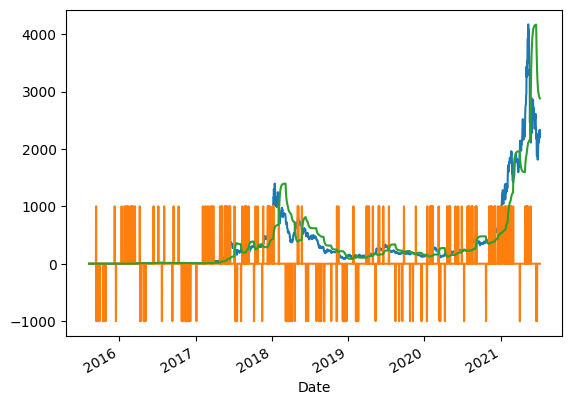

In [57]:
import pandas as pd

def calculate_hlt(df, length=23, offset=4, use_high_and_low=False, ema_period=9):
    # Use high, low or close based on the input flag
    src = df['high'] if use_high_and_low else df['close']

    # Calculate highest and lowest values with the specified length and offset
    df['hlt_upper'] = src.rolling(window=length).max().shift(offset)
    df['hlt_lower'] = src.rolling(window=length).min().shift(offset)

    # Initialize HLT series
    hlt = pd.Series(index=df.index, dtype='float64')

    for i in range(len(df)):
        if src.iloc[i] > df['hlt_upper'].iloc[i]:
            hlt.iloc[i] = df['hlt_lower'].iloc[i]
        elif src.iloc[i] < df['hlt_lower'].iloc[i]:
            hlt.iloc[i] = df['hlt_upper'].iloc[i]
        else:
            hlt.iloc[i] = hlt.iloc[i-1] if i > 0 else 0.0

    df['hlt'] = np.sign(hlt.diff())
    df['hlt_ema'] = hlt.ewm(span=ema_period, adjust=False).mean()

    return df[['hlt','hlt_ema']]

df_with_hlt = calculate_hlt(X)
df_with_hlt.hlt = df_with_hlt.hlt * 1000
X.close.plot()
df_with_hlt.hlt.plot()
df_with_hlt.hlt_ema.plot()

In [75]:
import pandas as pd
import numpy as np
import pandas_ta as ta

class TradingIndicator:
    def TradingIndicator(self, price_column='close', methods=['phi_smoother', 'tema', 'dema', 'wma', 'ema', 'sma'], lengths=None):
        self.price_column = price_column
        self.methods = methods
        self.lengths = lengths
        if self.lengths is None:
            self.lengths = list(range(5, 165, 5))

    def phi_smoother(self, df, column, length, phase=3.7):
        SQRT_PIx2 = np.sqrt(2.0 * np.pi)
        MULTIPLIER = -0.5 / 0.93
        length_2 = length * 0.52353

        if length > 1:
            weights = []
            for i in range(length):
                alpha = (i + phase - length_2) * MULTIPLIER
                beta = 1.0 / (0.2316419 * abs(alpha) + 1.0)
                phi = (np.exp(alpha**2 * -0.5) * -0.398942280) * beta * \
                    (0.319381530 + beta * (-0.356563782 + beta * \
                    (1.781477937 + beta * (-1.821255978 + beta * 1.330274429)))) + 1.011
                if alpha < 0:
                    phi = 1.0 - phi
                weight = phi / SQRT_PIx2
                weights.append(weight)

            weights = np.array(weights)
            if column in df.columns:
                df_smooth = df[column].rolling(window=length).apply(lambda x: np.dot(x[-len(weights):], weights) / np.sum(weights), raw=True)
                return df_smooth
            else:
                raise ValueError(f"Column '{column}' not found in DataFrame.")
        else:
            return df[column]


    def tema(self, series, length):
        return ta.tema(series, length=length)

    def dema(self, series, length):
        return ta.dema(series, length=length)

    def wma(self, series, length):
        return ta.wma(series, length=length)

    def ema(self, series, length):
        return ta.ema(series, length=length)

    def sma(self, series, length):
        return ta.sma(series, length=length)

    def compute_ribbon(self, df, price_column, methods, lengths):
        ribbons = {}
        for method in methods:
            method_function = getattr(self, method)
            if method == 'phi_smoother':
                # Special handling for phi_smoother, which needs the DataFrame and column name
                ribbons[method] = [method_function(df, price_column, length) for length in lengths]
            else:
                # For other methods, assuming they only need the series and length
                ribbons[method] = [method_function(df[price_column], length) for length in lengths]
        return ribbons


    def _transform(self, X, y = None):
        ribbons = self.compute_ribbon(X, self.price_column, self.methods, self.lengths)

        oscillator_values = []
        # Calculating the slope of each ribbon and oscillator values
        for method in self.methods:
            for length in self.lengths:
                ribbon = ribbons[method][self.lengths.index(length)]
                X[f'{method}_{length}_slope'] = ribbon.diff()

            # Calculating ribbon differences
            ribbon_diff = ribbons[method][0] - ribbons[method][-1]
            X[f'{method}_ribbon_diff'] = ribbon_diff
            X[f'{method}_volatility'] = ribbon_diff.rolling(window=30).std()
            oscillator_values.append(ribbon_diff)

        # Simple oscillator: average of differences
        X['composit_trend'] = np.mean(oscillator_values, axis=0)

        return_columns = ['composit_trend'] + [ f'{method}_ribbon_diff' for m in self.methods] + [ f'{method}_volatility' for m in self.methods]
        return X[return_columns]




# Usage
indicator = TradingIndicator()
df_with_indicators = indicator._transform(X)
df_with_indicators.composite_oscillator.plot()
df_with_indicators.close.plot()

AttributeError: 'TradingIndicator' object has no attribute 'price_column'

## Spectral entropy

In [81]:

from scipy.signal import welch
from scipy.stats import entropy


def spectral_entropy(time_series, sf, method='welch', nperseg=None, normalize=False):
    """
    Calculate the Spectral Entropy of a time series.

    Parameters:
    time_series (array-like): The time series data.
    sf (float): The sampling frequency of the time series.
    method (str): Method of spectral density estimation ('welch' by default).
    nperseg (int or None): Length of each segment for Welch's method. Defaults to None.
    normalize (bool): If True, normalize the entropy by log2 of the number of frequencies.

    Returns:
    float: Spectral Entropy
    """
    # Compute the spectral density
    freqs, psd = welch(time_series, sf, nperseg=nperseg)

    # Normalize the power spectral density
    psd_norm = psd / psd.sum()

    # Compute the Spectral Entropy
    se = entropy(psd_norm, base=2)

    if normalize:
        se /= np.log2(psd_norm.size)

    return se

def calculate_spectral_entropy(df, sf, nperseg=None, normalize=False):
    """
    Calculate the spectral entropy for each column of a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the time series data.
    sf (float): The sampling frequency of the time series.
    nperseg (int or None): Length of each segment for Welch's method. Defaults to None.
    normalize (bool): If True, normalize the entropy by log2 of the number of frequencies.

    Returns:
    pandas.DataFrame: DataFrame with the calculated spectral entropy for each column.
    """
    # Create a DataFrame to store spectral entropy values
    se_df = pd.DataFrame()

    for column in df.columns:
        # Calculate the spectral entropy for the column
        se = spectral_entropy(df[column].values, sf, nperseg=nperseg, normalize=normalize)
        se_df[column + '_SE'] = [se]

    return se_df

# Example usage
# Creating a sample DataFrame with random time series data
np.random.seed(42)
sample_df = pd.DataFrame({
    'Signal_1': np.random.normal(size=1000),
    'Signal_2': np.random.normal(size=1000)
})

# Calculate spectral entropy for each column in the DataFrame
se_results = calculate_spectral_entropy(sample_df, sf=100, normalize=True)
se_results



,Signal_1_SE,Signal_2_SE
0,0.9854,0.9835
